# !!! GET INTRO TOGETHER

#### !!! PUT IN DATA SET DESCRIPTION 
> REFERENCE THE PROJECT PLAN DOCUMENT SUBMITTED, 

#### !!! NARRATIVE
>HAVE CLEAR SCOPE
BRING IN WHAT DOING AND WHY WITH WHICH DATA

https://en.wikipedia.org/wiki/Wine_tasting_descriptors

#### Working in dataframe, text to list, load stopwords, tdidf -> extract keywords 
https://kavita-ganesan.com/extracting-keywords-from-text-tfidf/#.Xlv7LEp7k2w
https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.Xlv8c0p7k2w
#### Text classification model
https://kavgan.github.io/nlp-in-practice/text-classification/

#### Classification, W2V, BOW, TFIDF, GUIDE TO NLP
https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e
https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb

#### Good EDA and visualization tutorial
https://migsena.com/build-and-visualize-word2vec-model-on-amazon-reviews/

#### Text classification benchmarking with W2V, BOW, TFIDF, SVM and TFIDF works best?
http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/
https://github.com/nadbordrozd/blog_stuff/blob/master/classification_w2v/benchmarking_python3.ipynb

#### Text classification model - new to machine learning
https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a
https://github.com/javedsha/text-classification/blob/master/Text%2BClassification%2Busing%2Bpython%2C%2Bscikit%2Band%2Bnltk.ipynb

#### Create list of list and cosine, w2v - car make model, dataframe, not svm, lr, other, but good
https://github.com/zhlli1/Genism-word2vec/blob/master/Genism%20Word2Vec%20Tutorial.ipynb

#### Exploring wine reviews with nlp and kmeans, kaggle
https://www.kaggle.com/kitakoj18/exploring-wine-descriptions-with-nlp-and-kmeans

#### No classification models, but interesting, dataframe, lists, w2v ..
https://www.guru99.com/word-embedding-word2vec.html

https://stats.stackexchange.com/questions/286579/how-to-train-sentence-paragraph-document-embeddings
     https://github.com/nadbordrozd/blog_stuff/blob/master/classification_w2v/benchmarking_python3.ipynb
http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

https://turgutozkan.org/2018/11/21/gensim-tutorial-2-word2vec-and-doc2vec/

https://stackabuse.com/text-classification-with-python-and-scikit-learn/

from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier

etree_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v_tfidf = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    ("extra trees", ExtraTreesClassifier(n_estimators=200))])
    
TF-IDF is the product of two metrics: term frequency (TF) and inverse-document frequency (IDF). The term TF is what we had computed in the bag of words model (the raw frequencies of terms). Inverse document frequency, IDF, is computed by dividing the total number of documents in our corpus by the document frequency for each term and then applying logarithmic scaling on the result. The IDF is a measure of how much information the term provides through checking whether it is common or rare across all documents.

The idea here is to scale down the impact of terms that occur very frequently in a given corpus, which are probably less informative than terms occurring rarely in the training corpus. A high weight in TF–IDF is reached by a high representation in a given document and a low representation in a corpus (all documents).

Word2Vec
Google defines Word2Vec process as in the following: “The word2vec tool takes a text corpus as input and produces the word vectors as output. It first constructs a vocabulary from the training text data and then learns vector representation of words. The resulting word vector file can be used as features in many natural language processing and machine learning applications. Word2Vec accomplish its promises through an implementation of two alternative methods for word embeddings: the continuous bag-of-words and skip-gram.”[2]

Some Points to Keep in Mind
Word2vec models use a neural network of a single layer and capture the weights of the hidden layer, which represents the “word embeddings.”
In Word2vec framework, semantically similar words are placed close to one another.
The CBOW model predicts the center words using the context. Context can be thought as surrounding words.
The skip-gram model predicts the context words using the center words.
Word2vec reduces the size of the vector space
In simple terms, Word2Vec takes a text corpus as input and return word vectors as output with building vocabulary from the training data. Then, you just use those vectors as features of your model.

Analysis: 
Talk to price, why such wide range, concentration, and legitimacy of values. 
Talk to rating scale and what happening.
Talk to how going to approach analysis, segments, varietals, specific region for specific varietal.
Talk to complication of wine market, Rhone, multiple regions, each has a specific recipe and rules. Diff than that of US
US Syrah, not always all Syrah, over certain percentage, may be blended with Viognier, Grenache, Mouvedre, etc ..., but called Syrah
So Syrah in US may not be similar to Syrah in Australia or France, all have rules. 
Also flavor different,terrior as it is called, a 100% syrah in diff parts of France or US or Australia will taste different within their own country and in contrast to other parts of world. This is function of weather, soil, and farming practices.

For these reasons breaking down analysis. Will use high level aggregations to identify common threads for flavor, smell characteristics to find variatal similarities. Will value based on specific province/region combination. Will recommend using user preferences, rating/review perception of quality, and similarities to other varietals.

Other issues, if don't look on a varietal basis, then can be deceiving. Example Rhone grows Syrah, Bordeaux will not have Syrah reviews. Rhone considered one of, if not the best Syrah growing region, particularly Hermitage and Cote Rotie. To compare Hermitage with Croze hermitage is like comparing the best wine region in California to central Valley mass market farming. One is targeting the high end, the "Luxury" market, the other the low end, the "Everyday" market, to say another way. 

So the wine market is complex, best way to approach is by variety, and by segment and to avoid generalizing too much as the price/rating scales will lose meaning and not be of use to the consumer and business. 

As we are building an app to help the consumer, we want to make accurate predictions. 

Let's go over this reasoning with bivariate analysis.


In [1]:
# !!! ORGANIZE - CLEAN UP
import pandas as pd
import numpy as np

import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import libraries to build Word2Vec model, and load Newsgroups data
import os
import sys
import re

from collections import Counter

# NLP
import nltk
#from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
from nltk.stem.porter import *
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import spacy
from wordcloud import WordCloud #, STOPWORDS
import gensim
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
stemmer = SnowballStemmer("english")

# DIMENSION REDUCTION AND CLUSTERING
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD # Dimensional Reduction
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors # KNN Clustering 
from scipy.sparse import csr_matrix # Compressed Sparse Row matrix

# MODELS
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing, ensemble
from sklearn.preprocessing import Normalizer

# MODEL SELECTION
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

# METRICS AND REPORTING
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error

# PIPELINE
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# TIME BENCHMARKING
import time

### Part 1: Load the data

#### Aggregate data files to get more wine reviews. 

In [2]:
# LOAD FILE FROM CSV PUT INTO ONE DATAFRAME
wine_130k = pd.read_csv(("../FilesToLoad/wine-reviews/winemag-data-130k-v2.csv"))
wine_150k = pd.read_csv(("../FilesToLoad/wine-reviews/winemag-data_first150k.csv"))
df = pd.concat([wine_150k, wine_130k],axis=0, sort=False)
#wine = wine_150k
print("Number of rows and columns:",df.shape)

Number of rows and columns: (280901, 14)


In [3]:
# (COLUMNS, ROWS) IN CONATENATED DATAFRAME
df.shape

(280901, 14)

In [4]:
# CHECK THAT DATA TYPES APPEAR TO BE CORRECT, AND LOOK AT COUNTS
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280901 entries, 0 to 129970
Data columns (total 14 columns):
Unnamed: 0               280901 non-null int64
country                  280833 non-null object
description              280901 non-null object
designation              197701 non-null object
points                   280901 non-null int64
price                    258210 non-null float64
province                 280833 non-null object
region_1                 234594 non-null object
region_2                 111464 non-null object
variety                  280900 non-null object
winery                   280901 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 32.1+ MB


### Part 2: Clean Data

#### Duplicates exist in description, but are missed if analyzing duplicate for row as some reviews have twitter handles and others do not.

In [5]:
# DUPLICATE COUNTS (ROWS, COLUMNS)
print("Row level duplicates:   {}".format(df[df.duplicated()].shape))
print("Description duplicates: {}".format(df[df.duplicated('description')].shape))

# VIEW DUPLICATES
#df[df.duplicated(subset='description', keep=False)==True].sort_values(by='description', ascending=True).head(2)

Row level duplicates:   (0, 14)
Description duplicates: (111471, 14)


In [6]:
# DROP DUPLICATES AND UNNEEDED COLUMN
df.drop_duplicates('description', keep='first', inplace=True)
# DROP 'Unnamed: 0 FROM DATAFRAME
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# NEW DATAFRAME SHAPE
print("Description duplicates: {}".format(df[df.duplicated('description')].shape))
print("Dataframe shape: {}".format(df.shape))

Description duplicates: (0, 13)
Dataframe shape: (169430, 13)


#### Primary columns are points, price and description, variety, winery and country. Remove review rows where there are null values in a primary category.  

In [7]:
df.dropna(axis=0, subset=['country','price', 'variety'], inplace=True)

## Step 3: EDA, Preprocessing, and Feature Engineering

#### IMPORTANT FEATURE: each row has a review feature named 'description'.

In [8]:
pd.set_option('display.max_colwidth', -1)
print("Sample highest point rating review:")
print(df[df['points']==100]['description'].head(1))
print()
print("Sample mean point rating review:")
print(df[df['points']==90]['description'].head(1))
print()
print("Sample lowest point rating review:")
print(df[df['points']==80]['description'].head(1))

Sample highest point rating review:
2145    Full of ripe fruit, opulent and concentrated, this is a fabulous and impressive wine. It has a beautiful line of acidity balanced with ripe fruits. The wood aging is subtle, just a hint of smokiness and toast. This is one of those wines, from a great white wine vintage, that will age many years. Drink from 2024.
Name: description, dtype: object

Sample mean point rating review:
30    This Bulgarian Mavrud presents the nose with suggestions of dried cherry, black plum, freshly ground black pepper and a whiff of eucalyptus. In the mouth it is balanced with soft tannins mingling with dried cherry, cassis and black plum.
Name: description, dtype: object

Sample lowest point rating review:
7793    Tropical, soapy aromas are yeasty and flat. Flavors of lychee and melon have no follow-through and finish mealy.
Name: description, dtype: object


#### Analysis  
There a re a lot of flavor descriptions, and some positive and negative adjectives and adverbs with likely one-off n-grams such as "no follow-through".

#### Text classification with NLP will be the primary focus of this project, but we will first need to explore the dataset and  consider relevant features for creating our application used to educate and suggest options to those newer to wine, particularly Generation Z.

#### Majority of wineries with reviews in this dataset are in US, France and Italy.

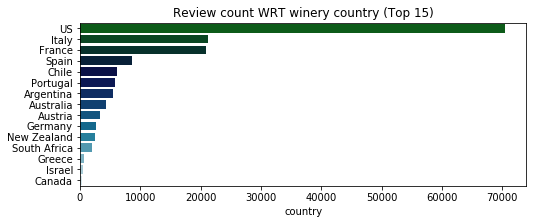

In [9]:
plt.figure(figsize=(8,3))
# CONVERT SERIES TO DATAFRAME. cnt IS DF WHERE INDEX IS COUNTRY AND COUNTS ARE FEATURE 
# cnt['country'] IS REVIEW COUNTS, NOT COUNTRY NAME
cnt = df['country'].value_counts().to_frame()[0:15]
#plt.xscale('log')
sns.barplot(x= cnt['country'], y =cnt.index, data=cnt, palette='ocean',orient='h')
plt.title('Review count WRT winery country (Top 15)');

#### We will use California in the US for this project. Will use CA pinot noir as it is the most reviewed varietal in this dataset. 

In [10]:
df[df['province']=='California']['variety'].value_counts().head(10)

Pinot Noir                  8828
Cabernet Sauvignon          7873
Chardonnay                  6899
Zinfandel                   3691
Syrah                       2668
Sauvignon Blanc             2473
Red Blend                   2213
Merlot                      2155
Bordeaux-style Red Blend    1194
Petite Sirah                914 
Name: variety, dtype: int64

#### Below is a view of the pinot noir reviews in California segmented by production regions.

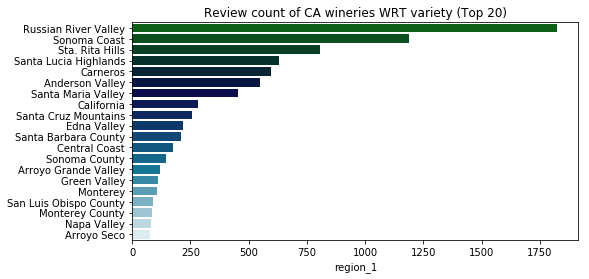

In [11]:
plt.figure(figsize=(8,4))
cnt = df[(df['country'] == 'US') & 
         (df['province'] =='California') & 
         (df['variety'] == 'Pinot Noir')]['region_1'].value_counts().to_frame()[0:20]
sns.barplot(x= cnt['region_1'], y =cnt.index, data=cnt, palette='ocean',orient='h')
plt.title('Review count of CA wineries WRT variety (Top 20)');

#### Create dataframe for the top 20 pinot noir production regions basedon review count. 

In [12]:
pn_region_list = ['Russian River Valley', 'Sonoma Coast', 'Sta. Rita Hills',
       'Santa Lucia Highlands', 'Carneros', 'Anderson Valley',
       'Santa Maria Valley', 'California', 'Santa Cruz Mountains',
       'Edna Valley', 'Santa Barbara County', 'Central Coast', 'Sonoma County',
       'Arroyo Grande Valley', 'Green Valley', 'Monterey',
       'San Luis Obispo County', 'Monterey County', 'Napa Valley',
       'Arroyo Seco']

# PRICE BASED DATAFRAME 
df_pn20_prc = df[(df['country'] == 'US') & 
                 (df['province'] =='California') & 
                 (df['variety'] == 'Pinot Noir') &
                 (df['region_1'].isin(pn_region_list))].copy()

#### Create a new index so can merge dataframes.

In [13]:
df_pn20_prc.reset_index();
df_pn20_prc.insert(0, 'rating_ID', range(0, len(df_pn20_prc)))

### Univariate Analysis

In [14]:
# .T TRANSPOSES DATAFRAME
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,156552,48,US,70491,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,156552,156552,"Blatant green aromas of bell pepper and thyme are the dominant aromas. A raw, tannic, edgy mouthfeel and herbal, green flavors are patently Chilean and compounded by this cool vintage. Mint and leftover green flavors take up space on a bullish, tannic finish.",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
designation,110034,44351,Reserve,2802,NaN,NaN,NaN,NaN,NaN,NaN,NaN
points,156552,NaN,NaN,NaN,88.1924,3.15024,80,86,88,90,100
price,156552,NaN,NaN,NaN,34.6458,39.3853,4,16,25,40,3300
province,156552,483,California,48458,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_1,130976,1307,Napa Valley,6401,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_2,67184,18,Central Coast,14504,NaN,NaN,NaN,NaN,NaN,NaN,NaN
variety,156552,739,Pinot Noir,15983,NaN,NaN,NaN,NaN,NaN,NaN,NaN
winery,156552,18143,Williams Selyem,299,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Price outlier with boxplot
Although there is a wide range of prices, the outliers are legitimate price observations. Certain wineries command a premium due to quality, scarcity, and prestige. The observations are based on price per 750ml.

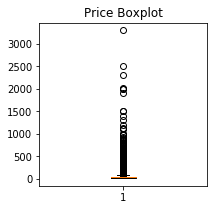

In [15]:
# BOXPLOT
plt.figure(figsize=(3,3))
plt.boxplot(df['price'],whis=1.5)
plt.title('Price Boxplot')
plt.show()

#### Price - Distribution

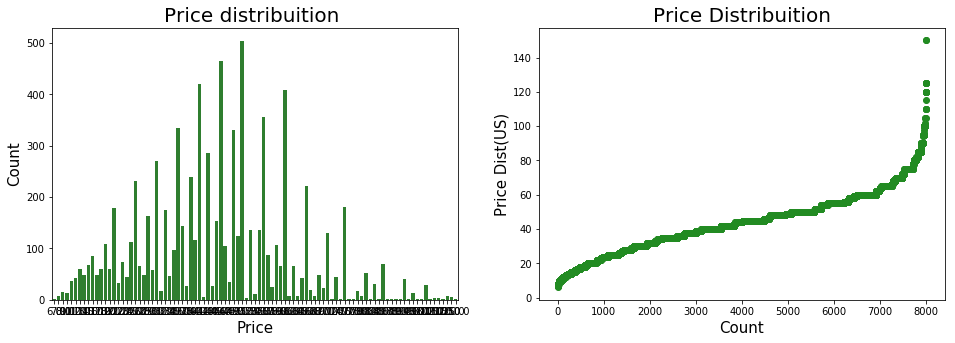

In [16]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1) 
prc = sns.countplot(x='price', data=df_pn20_prc, color='forestgreen') 
prc.set_title("Price distribuition ", fontsize=20) 
prc.set_xlabel("Price", fontsize=15)
prc.set_ylabel("Count", fontsize=15)

plt.subplot(1,2,2)
plt.scatter(range(df_pn20_prc.shape[0]), np.sort(df_pn20_prc.price.values), color='forestgreen') # creating a cumulative distribution
plt.xlabel('Count', fontsize=15)
plt.ylabel('Price Dist(US)', fontsize=15) 
plt.title("Price Distribuition", fontsize=20)
plt.show() #rendering the graphs

#### Rating ("points") outlier with boxplot
>Majority of ratings rank the wines between 86 and 90 points where greater than 90 points appears to be a designation for an above average wine, and less than 86.

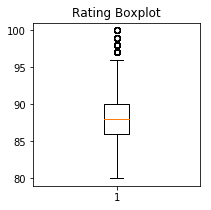

In [17]:
# BOXPLOT
plt.figure(figsize=(3,3))
plt.boxplot(df['points'],whis=1.5)
plt.title('Rating Boxplot')
plt.show()

#### Point Distribution

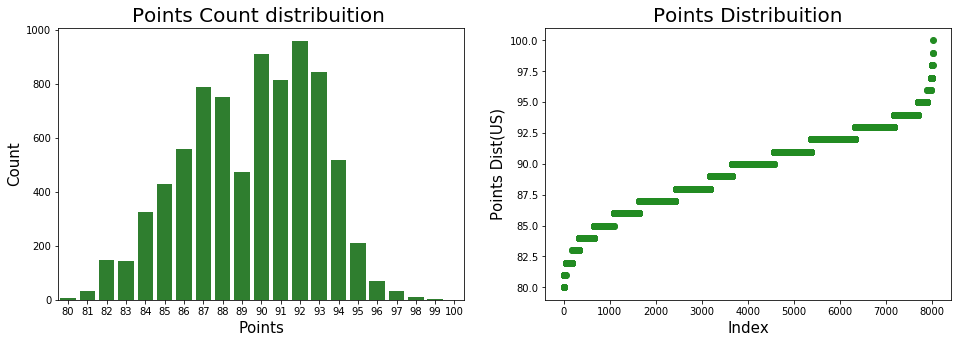

In [18]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
g = sns.countplot(x='points', data=df_pn20_prc, color='forestgreen') 
g.set_title("Points Count distribuition ", fontsize=20)
g.set_xlabel("Points", fontsize=15)
g.set_ylabel("Count", fontsize=15)

plt.subplot(1,2,2)
plt.scatter(range(df_pn20_prc.shape[0]), np.sort(df_pn20_prc.points.values), color='forestgreen') # creating a cumulative distribution
plt.xlabel('Index', fontsize=15)
plt.ylabel('Points Dist(US)', fontsize=15)
plt.title("Points Distribuition", fontsize=20)

plt.show()

#### Classify rating W.R.T. length of text wine review
Appears there is a relationship between a long review and a high rating score. 

In [19]:
# PUT LENGTH FEATURE INTO PRICE AND RATING DATAFRAMES
df_pn20_prc = df_pn20_prc.assign(desc_length = df_pn20_prc['description'].apply(len))

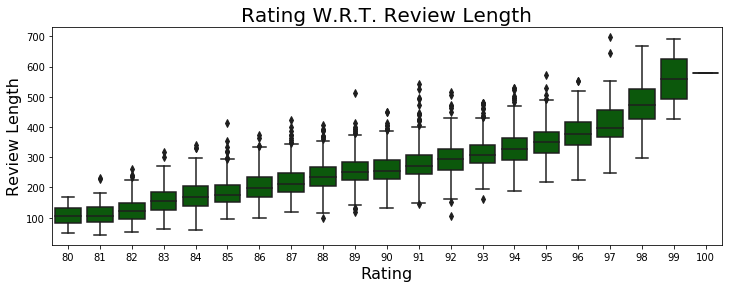

In [20]:
plt.figure(figsize=(12,4))
prc_bp = sns.boxplot(x='points', y='desc_length', data=df_pn20_prc,
                color='darkgreen')
prc_bp.set_title('Rating W.R.T. Review Length', fontsize=20)
prc_bp.set_ylabel('Review Length', fontsize = 16) # Y label
prc_bp.set_xlabel('Rating', fontsize = 16) # X label
plt.show()

### Bivariate Analysis

#### Price by region

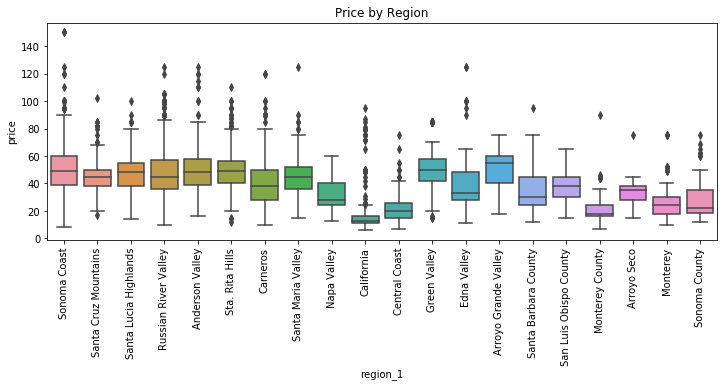

In [21]:
plt.figure(figsize=(12,4))
sns.boxplot(x=df_pn20_prc['region_1'], y=df_pn20_prc['price'])
plt.title('Price by Region')
plt.xticks(rotation=90);

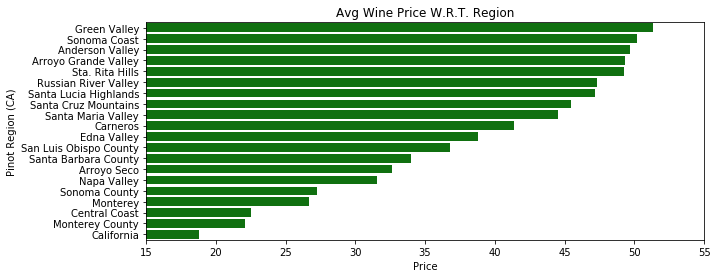

In [22]:
cnt = df_pn20_prc.groupby(['region_1']).mean()['price'].sort_values(ascending=False).to_frame()[0:20]
fig,ax = plt.subplots(figsize=(10,4))
sns.barplot(x= cnt['price'], y=cnt.index, data=cnt, color='green', orient='h')#palette='ocean',)
ax.set(xlim=(15, 55))
ax.set(title='Avg Wine Price W.R.T. Region')
ax.set(xlabel='Price')
ax.set(ylabel='Pinot Region (CA)');

#### Rating by Region

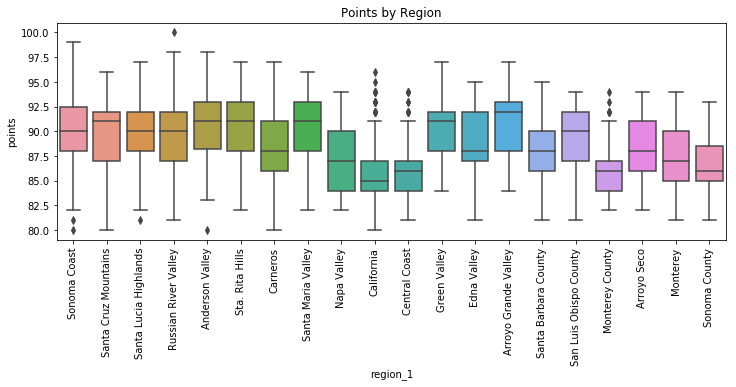

In [23]:
plt.figure(figsize=(12,4))
sns.boxplot(x=df_pn20_prc['region_1'], y=df_pn20_prc['points'])
plt.title('Points by Region')
plt.xticks(rotation=90);

#### Point rating density: Two histograms, one 90 and below, the other 91 and above

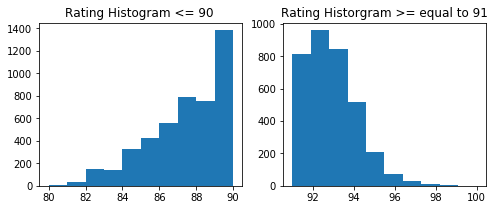

In [24]:
plt.figure(figsize=(8,3))

plt.subplot(1, 2, 1)
plt.hist(df_pn20_prc[df_pn20_prc['points']<=90]['points'])
plt.title("{}".format('Rating Histogram <= 90 ')) 

plt.subplot(1, 2, 2)
plt.hist(df_pn20_prc[df_pn20_prc['points']>=91]['points'])
plt.title("{}".format('Rating Historgram >= equal to 91'))   

plt.show();

#### Analysis
Average price by region has a large difference from highest price to lowest price.  
The range of price is larger than the range of rating, as price has no upper boundary and rating boundary is fixed with lower boundary = 80, upper boundary 100. 

The ratings will ultimately be grouped and become the classification target. Price appears to have variance and value as a feature.  

#### Target variable
As review observations appear to be group by 91 and above, and 90 and below will assign a rank variable of 0 and 1 to be used as a classification target.

In [25]:
# RANK
df_pn20_prc['point_rank']=pd.qcut(df_pn20_prc['points'],2,labels=False)
df_pn20_prc['point_rank'].value_counts()

0    4560
1    3453
Name: point_rank, dtype: int64

### One Hot Encoding
Regions appear to have an impact on point ratings. Create binary features for each region for use later. 

In [26]:
one_hot_list_all = []
cat_list = ['region_1']

for feature in cat_list:
    df_pn20_prc = pd.concat([df_pn20_prc, pd.get_dummies(df_pn20_prc[feature], prefix=feature, 
                                                         drop_first=False)], axis=1)
    one_hot_list_all.extend(list(pd.get_dummies(df_pn20_prc[feature], prefix=feature, 
                                                drop_first=True).columns))
    df_pn20_prc.drop(feature, axis=1, inplace=False) 

In [27]:
print(df_pn20_prc.shape)
print(df_pn20_prc.columns)
#df_pn20_prc.head(3)

(8013, 36)
Index(['rating_ID', 'country', 'description', 'designation', 'points', 'price',
       'province', 'region_1', 'region_2', 'variety', 'winery', 'taster_name',
       'taster_twitter_handle', 'title', 'desc_length', 'point_rank',
       'region_1_Anderson Valley', 'region_1_Arroyo Grande Valley',
       'region_1_Arroyo Seco', 'region_1_California', 'region_1_Carneros',
       'region_1_Central Coast', 'region_1_Edna Valley',
       'region_1_Green Valley', 'region_1_Monterey',
       'region_1_Monterey County', 'region_1_Napa Valley',
       'region_1_Russian River Valley', 'region_1_San Luis Obispo County',
       'region_1_Santa Barbara County', 'region_1_Santa Cruz Mountains',
       'region_1_Santa Lucia Highlands', 'region_1_Santa Maria Valley',
       'region_1_Sonoma Coast', 'region_1_Sonoma County',
       'region_1_Sta. Rita Hills'],
      dtype='object')


### Wine market segmentation
Generally speaking the wine market is broken up into segments based on price. There are certainly customer demographics that are important to the wine industry, but for this project we don't have access to that data.  

Price segmentation.  

Some have grouped the wine market into three general categories (super segments). Note this is for all varietals.  These segments are:  
Everyday (in an efficient market, lower price, lower rating)  
Premium  
Luxury   (in an efficient market, higher price, higher rating)  
 
This project chose two categories to classify, premium and luxury.  
0: Premium  
1: Luxury   in an efficient market, higher price, higher rating)

Here is the reasoning. Pinot noir has a thin skin, and the yield per acre, particularly for high end pinot (drop fruit for concentration), is significantly lower than Cabernet Sauvignon for example. Moreover pinot is more susceptiable to adverse weather variables such as temperature and moisture. This increases cost of production. For the most part, pinot noir has a higher cost of production and thus not used as frequently for mass market bottlings at an "everyday" price point (think box wines and bottles < $7). Certainly there are lower price point pinot's, but on the whole, pinot, particularly in the reviews in this dataset (bias will be addressed in summary), is not frequently reviewed, in the "everyday" segment.  

To conclude, two super segment categories will be used to classify the pinot reviews as actual point predictions would be highly nuanced and likely curve fit and not generalize well.

Please not the author is not in the wine industry, but does have some domain knowledge to speak beyond recreational consumption. 

#### Price and point rating analysis

In [28]:
df_pn20_prc[df_pn20_prc['price']>25].describe()

,rating_ID,points,price,desc_length,point_rank,region_1_Anderson Valley,region_1_Arroyo Grande Valley,region_1_Arroyo Seco,region_1_California,region_1_Carneros,...,region_1_Napa Valley,region_1_Russian River Valley,region_1_San Luis Obispo County,region_1_Santa Barbara County,region_1_Santa Cruz Mountains,region_1_Santa Lucia Highlands,region_1_Santa Maria Valley,region_1_Sonoma Coast,region_1_Sonoma County,region_1_Sta. Rita Hills
count,6688.000000,6688.000000,6688.000000,6688.000000,6688.000000,6688.000000,6688.000000,6688.000000,6688.000000,6688.000000,...,6688.000000,6688.000000,6688.000000,6688.000000,6688.000000,6688.000000,6688.00000,6688.000000,6688.000000,6688.000000
mean,4026.972039,90.154456,49.054874,268.023325,0.503738,0.078050,0.016447,0.008523,0.004934,0.073116,...,0.007775,0.247458,0.011065,0.020634,0.037081,0.088367,0.06265,0.161633,0.008224,0.116477
std,2322.812415,3.075381,14.755567,71.269390,0.500023,0.268271,0.127198,0.091931,0.070076,0.260346,...,0.087840,0.431567,0.104613,0.142166,0.188975,0.283849,0.24235,0.368141,0.090318,0.320820
min,0.000000,80.000000,26.000000,43.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,2004.750000,88.000000,38.000000,221.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,4036.500000,91.000000,48.000000,266.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,6037.250000,92.000000,58.000000,313.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,8012.000000,100.000000,150.000000,697.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


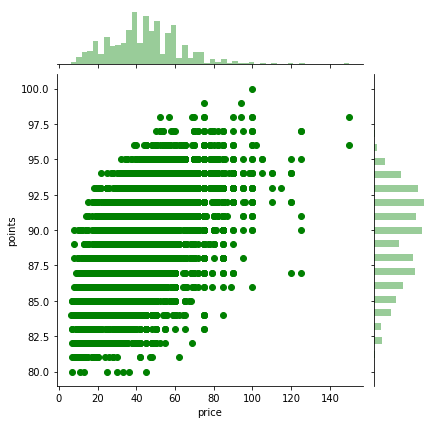

In [29]:
sns.jointplot(x=df_pn20_prc['price'], y=df_pn20_prc['points'], color='g');

#### Analysis

General price values for super segments:   
0: Premium: > 7 and <= 25  
1: Luxury: > 25   

>When looking at the rating (point) range, there appears to be a wide price range for each target category.  
>0: points 80 -> 90, price 6 -> 125   
1: points 91 -> 100, price 14 -> 150   

>When looking at the price range, there is also a wide range for target categories.  
>0: price <= 25,  points 80 -> 94    
1: price >  25,  points 80 -> 100  

It would appear that predicting the target category on just price may be hard to do.  

For the consumer it would appear that there are opportunities to purchase a wine priced as premium with high ratings, and a wine priced as luxury with low ratings. The market appears to be inefficient. Note farming has a lot of risk and variables, but for the purpose of suggesting and educating the consumer, there appears to be opportunities to get quality at a more reasonable price point for those that are price sensative and not seeking prestige and scarcity value. 

### Standardize features
Prior to clustering with UMAP will standardize our features and apply to dataframe with new names. 

In [30]:
from sklearn.preprocessing import StandardScaler, PowerTransformer # Yeo-Johnson or Boxcox

pt = PowerTransformer(standardize=True, copy=False, method ='box-cox')
df_trans = pt.fit_transform(df_pn20_prc[['price', 'desc_length']])
df_trans = pd.DataFrame(df_trans, columns=['prc_bc', 'desc_len_bc'])

In [31]:
df_trans.insert(0, 'rating_ID', range(0, len(df_trans)))
df_pn20_prc = df_pn20_prc.merge(df_trans, on='rating_ID', how='left')

### Correlation between features

In [32]:
corr=df_pn20_prc[['points','prc_bc','desc_len_bc']].corr()
corr.style.background_gradient(cmap = 'coolwarm')

,points,prc_bc,desc_len_bc
points,1,0.577789,0.73926
prc_bc,0.577789,1,0.45348
desc_len_bc,0.73926,0.45348,1


#### Analysis
Description length has a high correlation with points, but medium correlation with price. 

### Chi-2 for binary feature analysis
As regions are now a binary feature, we could analyze to see if there is collinearity in that feature class. As this is a classification model we will not run the Chi-2 analysis. Given some of the boxplots, believe it is a reasonable assumption that some regions are highly correlated with others. This should not impact our classification models.

### Visualization with Dimension Reduction and Clustering
Visualize point ranking with respect to (W.R.T.) description length. Significance is to use unstructured learning to visualize clusters and perhaps best number of classifier categories. Since using NLP primarily, will focus on a basic engineered feature description length. 

#### UMAP: Dimension Reduction visualization

# !!! TURN BACK ON

import umap

X = df_pn20_prc[['desc_len_bc', 'price']]
X.values

umap_results = umap.UMAP(n_neighbors=20, min_dist=1,
                         metric='correlation').fit_transform(X)

plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

#### KMEANS Clustering
# !!! TURN BACK ON

# DETERMINE OPTIMAL CLUSTER NUMBER 
# ELBOW METHOD -> WITHIN CLUSTER SUM OF SQUARES (WCSS)
from sklearn.cluster import KMeans
wcss = []
for i in range(1,8):
    kmeans = KMeans(n_clusters = i, init = 'random', max_iter = 300,
                    n_init = 10, random_state = 42)
    kmeans.fit(df_pn20_prc[['desc_len_bc','prc_bc']])
    wcss.append(kmeans.inertia_)
plt.plot(range(1,8), wcss)
plt.title('Elbow Method')
plt.xlabel('# Clusters')
plt.ylabel('WCSS')
plt.show()

#### Agglomerative Clustering with dendrogram, 'ward' method
# !!! TURN BACK ON

plt.figure(figsize=(20,10))
dendrogram(linkage(df_pn20_prc[['desc_len_bc','prc_bc']], method='ward'))
plt.show()

#### Clustering analysis
UMAP not showing seperation.  
KMEANS elbow method places clusters at 2 or 3, which is inline with Super Segments, and the choice of two clusters.
Agglomerative Clustering places into two clusters. 

Appears that the choice of two two target categories to classify is reasonable according to clustering methods.  

#### Benchmark pre NLP feature engineering

#### Benchmark price and description length 

In [33]:
X = df_pn20_prc[['prc_bc','desc_len_bc']]
y = df_pn20_prc['point_rank']

In [34]:
logreg = LogisticRegression(solver='lbfgs',max_iter=50000, multi_class='auto')
score_fs = cross_val_score(logreg, X, y, scoring="accuracy", cv=3)   
print("mean={:.2f}   std=(+/- {:.2f})   all={} ".format(score_fs.mean(),
                                                        score_fs.std()*2, score_fs))

mean=0.80   std=(+/- 0.02)   all=[0.80456758 0.80643954 0.77948334] 


#### Benchmark regions

In [35]:
X = df_pn20_prc.iloc[:,16:36]
y = df_pn20_prc['point_rank']

In [36]:
logreg = LogisticRegression(solver='lbfgs',max_iter=50000, multi_class='auto')
score_fs_pca = cross_val_score(logreg, X, y, scoring="accuracy", cv=3)   
print("mean={:.2f}   std=(+/- {:.2f})   all={} ".format(score_fs_pca.mean(),
                                                        score_fs_pca.std()*2, score_fs_pca))

mean=0.61   std=(+/- 0.03)   all=[0.58554848 0.60913516 0.62560839] 


#### Benchmark price, description length and regions

In [37]:
X = df_pn20_prc.iloc[:,16:]
y = df_pn20_prc['point_rank']

In [38]:
logreg = LogisticRegression(solver='lbfgs',max_iter=50000, multi_class='auto')
score_fs_pca = cross_val_score(logreg, X, y, scoring="accuracy", cv=3)   
print("mean={:.2f}   std=(+/- {:.2f})   all={} ".format(score_fs_pca.mean(),
                                                        score_fs_pca.std()*2, score_fs_pca))

mean=0.80   std=(+/- 0.03)   all=[0.80718832 0.81505054 0.7768626 ] 


#### Analysis
Price and description length: 80%  
Regions: 61%  
Price, description length and regions: 80%  

### NLP - TF-IDF and Topic Modeling
Put in a description of TF-IDF here

In [39]:
pd.set_option('display.max_colwidth', -1)
df_pn20_prc[df_pn20_prc['points'] == 96]['description'].head(1)

103    A best-of blend from several of the producer's vineyard sites, this wine explodes in flavor and complexity as though celebrating each site's individual beauty and potential. Black pepper and crisp orange and pomegranate flavors show through its layered and focused texture—a savory package with a seemingly endless finish.
Name: description, dtype: object

#### Create a stopwords variable. First run used default from Genism. Results were good. This run uses a modified stopword list. 

In [40]:
print(len(STOPWORDS))
stopwords = set(STOPWORDS)
newStopWords = ['fruit', "drink", "black", 'wine', "pinot", "noir", "palate", "flavor", "note",
                'russian', 'river', 'valley', 'sonoma', 'coast', 'sta', 'santa', 'rita', 'hills',
                'lucia', 'highlands', 'carneros', 'anderson', 'maria','california', 'santa', 
                'cruz', 'mountains','edna', 'barbara', 'central', 'coast', 'sonoma','county', 
                'arroyo', 'grande Valley', 'monterey', 'san', 'luis', 'obispo', 'monterey', 
                'napa', 'arroyo', 'seco', 'price','point','variety','accent', 'acid', 'add', 
                'alcohol', 'allspic', 'alongsid', 'anis', 'aroma', 
                'aromat', 'asian', 'bacon', 'bake', 'barrel',  'beef', 'beer', 'begin', 
                'berri',  'blackberri', 'blend', 'block', 'blueberri', 'bold', 'bone', 
                'bottl', 'boysenberri', 'brighten', 'bring', 'brisk', 'butter', 'caramel', 
                'cardamom', 'carri', 'case', 'cedar', 'cellar', 'charact', 'cherri', 'chocol',
                'cinnamon', 'climat', 'clone', 'coat', 'cocoa', 'coffe', 'cola', 'color', 
                'combin', 'come', 'cool', 'core', 'cranberri', 'crush', 'currant', 'dark', 
                'defin', 'deliv', 'design', 'despit', 'develop', 'dimension', 'direct', 
                'domin', 'dri', 'drink', 'drinkabl', 'drive', 'dryness',  'easi', 
                'element', 'emerg', 'especi', 'estat', 'eucalyptu', 'experi', 'express', 
                'extract', 'fairli', 'famili', 'fennel', 'flavor', 'focu', 'follow', 
                'food', 'forest', 'frame', 'fruit', 'fruiti', 'fulli', 'gener', 
                'glass', 'grape', 'graphit', 'grill', 'grow', 'hibiscu', 'hint', 'includ', 
                'juic', 'juici', 'junip', 'know', 'lace', 'lack', 'lamb', 'lavend', 'lead', 
                'leather', 'level', 'licoric', 'lift', 'light', 'lighter', 'lightli', 'like', 
                'littl', 'live', 'lot', 'make', 'mark', 'meat', 'meet', 'mellow', 'mocha', 
                'mulberri', 'near', 'need', 'noir', 'nose', 'note', 'nutmeg', 'offer', 'oliv', 
                'open', 'opul', 'orang', 'oregano', 'pack', 'pair', 'peel', 'pencil', 
                'pepper', 'peppercorn', 'pepperi', 'persimmon', 'pine', 'pinot', 'plant', 
                'plenti', 'plum', 'pomegran', 'produc', 'product', 'provid', 'purpl', 'rang', 
                'raspberri', 'readi', 'real', 'refin', 'region', 'releas', 'remain', 'result', 
                'rhubarb', 'right', 'rise', 'roast', 'root', 'round', 'rustic', 'sage', 
                'sagebrush', 'sandalwood', 'scent', 'select', 'singl', 'sit', 'site', 'skin', 
                'slightli', 'smell', 'smoke', 'smoki', 'somewhat', 'sourc', 'spice', 'spici', 
                'start', 'steak', 'strawberri', 'streak', 'style',  'support', 'tast', 'tasti', 
                'thyme', 'time', 'toast', 'toasti', 'tone', 'touch', 'turn', 
                'vanilla', 'variet', 'vineyard', 'vintag', 'violet', 'want', 'warm', 
                'weight', 'white', 'wild', 'win', 'wind', 'winemak', 'wineri', 'wonder', 
                'wrap', 'year']
stopwords.update(newStopWords)
print(len(stopwords))

337
590


#### Preprocessing functions: Lemmantize and stem 

Lemmantize         -> Intended part of speech (POS) for meaning of word in sentence  
Stemming           -> Reduce word to root form   
Standardize tense  -> Verb tenses to present, third and second person to first person  
Punctuation        -> Remove all   
Lower case         -> Words to lower case  
Tokenize           -> Split review to process on a word level  
Character filter   -> Ignore small words, words < three characters ignored  
Stopwords          -> Ignore common words that are frequent and perceived as low value  

In [41]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        #if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
        if token not in stopwords and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return " ".join(result)

In [42]:
df_pn20_prc['clean_desc'] = df_pn20_prc['description'].map(lambda x: preprocess(x))

In [43]:
print(df_pn20_prc['description'].head(1))
print()
print(df_pn20_prc['clean_desc'].head(1))

0    The producer sources from two blocks of the vineyard for this wine—one at a high elevation, which contributes bright acidity. Crunchy cranberry, pomegranate and orange peel flavors surround silky, succulent layers of texture that present as fleshy fruit. That delicately lush flavor has considerable length.
Name: description, dtype: object

0    produc sourc block high elev contribut bright acid crunchi cranberri pomegran orang flavor surround silki succul layer textur present fleshi delic lush consider length
Name: clean_desc, dtype: object


(-0.5, 399.5, 199.5, -0.5)

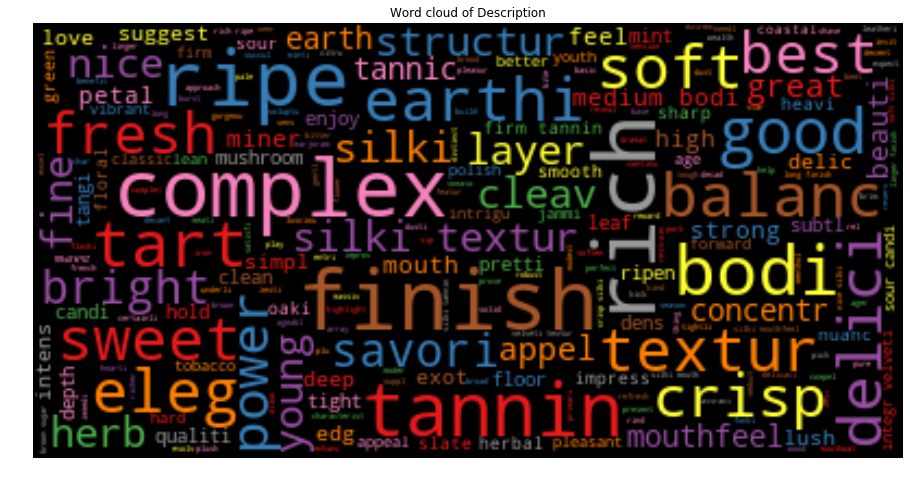

In [44]:
plt.figure(figsize= (16,8))
plt.title('Word cloud of Description')
wc = WordCloud(max_words=1000,max_font_size=40,
               background_color='black', 
               stopwords = stopwords, 
               #stopwords = STOPWORDS, 
               colormap='Set1')
wc.generate(' '.join(df_pn20_prc['clean_desc']))
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')

#### Analysis
The preprocessing has done a good job of removing common words. But it appears there are common words unique to wine reviews that look to not add value such as "pinot noir", "flavor", and a bunch of combinations of cherri.

The default was benchmarked and found that many words didn't look to be adding value, and another layer of filtering could explain more variance. Unfortunately TF-IDF does not appear to generalize well to wine reviews with default stopwords.

#### Start with ngram = 1, meaning no bi-grams or tri-grams, ie multiple words as one feature such as "pinot noir" or "cherry cola". Using min_df to filter amount of words to be considered.  

# !!! Give definition of min_df

In [45]:
tfidf_vect_ngram = TfidfVectorizer(
    #max_df=0.1,  # THIS DOESN'T APPEAR TO BE HAVING ANY IMPACT HIGH OR LOW
    min_df=0.01, 
    analyzer='word', 
    token_pattern=r'\w{1,}', 
    ngram_range=(1,1), 
    max_features=5000,
    #stop_words='english', 
    stop_words=stopwords, 
    lowercase=False,
    vocabulary=None)

# FIT ON ALL DOCUMENTS
tfidf_ngram = tfidf_vect_ngram.fit_transform(df_pn20_prc['clean_desc'])
tfidf_ngram_feat = tfidf_vect_ngram.get_feature_names()

C:\Users\DJ\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['Valley', 'grande'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [46]:
print(type(tfidf_ngram))
print(type(tfidf_ngram_feat))
#print(tfidf_ngram_feat)
print(df_pn20_prc.shape)
print(tfidf_ngram.shape)

<class 'scipy.sparse.csr.csr_matrix'>
<class 'list'>
(8013, 39)
(8013, 147)


#### Convert matrix to dataframe. View TF-IDF scores.

In [47]:
# USE THIS TO GET tfidf_ngram INTO DATAFRAME VS CSR MATRIX
# GO FROM SPARSE TO DENSE. SPARSE IS OPTIMIZED MATRIX FOR LOOKUP. 
dense = tfidf_ngram.todense()
denselist = dense.tolist()
# CONVERT LIST TO DATAFRAME, RENAME
df_tfidf_ngram_wine = pd.DataFrame(denselist, columns=tfidf_ngram_feat)
df_tfidf_ngram_wine.head(1)

,age,ageabl,ager,appeal,appel,approach,balanc,beauti,best,better,...,tough,unrip,veget,velveti,vibrant,wave,young,youth,zest,zesti
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Merge two dataframes by index

In [48]:
df_pn20_prc = pd.merge(df_pn20_prc, df_tfidf_ngram_wine, left_index=True, right_index=True);

In [49]:
print(df_pn20_prc.shape)

(8013, 186)


#### PCA: Reduce featues and benchmark

In [50]:
from sklearn.decomposition import PCA

# SET PCA ABOVE 80% VARIANCE EXPLAINED, HOWEVER MANY COMPONENTS
selector = PCA(n_components=.99).fit(X,y)
# SELECT # COMPONENTS
#selector = PCA(n_components=10).fit(X,y)
var_explained = selector.explained_variance_ratio_ 
var_explained = pd.Series(var_explained)
print(round(var_explained,4))

0     0.5063
1     0.1912
2     0.0678
3     0.0441
4     0.0317
5     0.0262
6     0.0244
7     0.0206
8     0.0133
9     0.0110
10    0.0101
11    0.0092
12    0.0077
13    0.0067
14    0.0056
15    0.0050
16    0.0046
17    0.0040
18    0.0037
dtype: float64


In [51]:
pca = PCA(n_components = 19)
logreg = LogisticRegression(solver='lbfgs',max_iter=50000)
pipeline = Pipeline([('pca', pca), ('logistic', logreg)])
score_fs_pca = cross_val_score(pipeline, X, y, scoring="accuracy", cv=3)   
print("mean={:.2f}   std=(+/- {:.2f})   all={} ".format(score_fs_pca.mean(),
                                                        score_fs_pca.std()*2, score_fs_pca))

mean=0.80   std=(+/- 0.03)   all=[0.80756271 0.81467615 0.77723699] 


#### Analysis 
Defaut Genism STOPWORD TF-IDF  
229 NLP Principal Components to explain 80% of the dataset.  
mean=0.77   std=(+/- 0.06)   all=[0.7768626  0.80868589 0.72968925]   

This run with customized stopwords TF-IDF  
19 NLP Principal Components to explain 99% of the dataset.  
mean=0.80   std=(+/- 0.03)   all=[0.80756271 0.81467615 0.77723699] 

#### UMAP: Dimension reduction visualization of TF-IDF scores.

# !!! turn back on
import umap
X = df_pn20_prc.iloc[:,39:]
X.values

umap_results = umap.UMAP(n_neighbors=20, min_dist=1,
                         metric='cosine').fit_transform(X)

plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

#### Clustering TF-IDF with KMeans

# !!! turn back on 
plt.figure(figsize= (8,4))

wcss = []
for i in range(1,15):
    kmeans = KMeans(n_clusters = i, init = 'random', max_iter = 300,
                    n_init = 10, random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,15), wcss)
plt.title('Elbow Method')
plt.xlabel('# Clusters')
plt.ylabel('WCSS')
plt.show()

#### Clustering TF-IDF with Agglomorative Clustering

# !!! turn back on 
plt.figure(figsize=(20,10))
dendrogram(linkage(X, method='ward'))
plt.show()

#### Analysis:
UMAP: Showing two groups, one large blob, the other a small. Note used cosine.  
K-Means: Steady decline, no leveling off. 
# !!! Research how does on high dimension. 
Agglomorative Clusering: Two primary groups, like UMAP, one large, one small. Ten sub groups.
    
Two clusters appears to be the number of TF-IDF clusters. We will use two for topics. 

#### Topic modeling - TF-IDF scores with LSA, LDA and NNMF

In [52]:
X = df_pn20_prc.iloc[:,39:]
y = df_pn20_prc['point_rank']

In [53]:
# Number of topics.
ntopics=2

# Number of words to look at for each topic.
n_top_words = 20

In [54]:
# Linking words to topics
def word_topic(tfidf, solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=[x for x in chosenlist]
    return(topwords)

In [55]:
# LSA
svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
wine_lsa = lsa.fit_transform(tfidf_ngram)

lsa_components = word_topic(tfidf_ngram, wine_lsa, tfidf_ngram_feat)

topwords=pd.DataFrame()
topwords['LSA']=top_words(lsa_components, n_top_words)  

In [56]:
# LDA
lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

lda_wine = lda.fit_transform(tfidf_ngram) 
lda_components = word_topic(tfidf_ngram, lda_wine, tfidf_ngram_feat)
topwords['LDA']=top_words(lda_components, n_top_words)

In [57]:
# NNMF
nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
nmf_wine = nmf.fit_transform(tfidf_ngram) 

nmf_components = word_topic(tfidf_ngram, nmf_wine, tfidf_ngram_feat)

topwords['NNMF']=top_words(nmf_components, n_top_words)

In [58]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic][0:40])

Topic 0:
               LSA             LDA            NNMF
0  rich 421.12      silki 193.44    tannin 25.88  
0  tannin 387.7     tannin 180.19   rich 25.83    
0  silki 382.49     finish 172.89   finish 25.32  
0  ripe 371.21      rich 172.41     ripe 23.97    
0  finish 365.13    soft 171.16     bodi 23.45    
0  complex 340.79   ripe 167.62     complex 17.04 
0  textur 336.61    tart 157.96     soft 15.64    
0  bodi 319.29      sweet 153.03    sweet 15.48   
0  sweet 306.97     textur 145.23   earthi 15.31  
0  soft 286.61      complex 142.94  textur 14.08  
0  good 272.89      good 137.55     balanc 13.79  
0  tart 261.95      bodi 133.28     tart 13.5     
0  crisp 236.36     earthi 131.67   structur 11.38
0  eleg 232.92      fresh 123.39    delici 11.33  
0  balanc 230.26    herb 119.03     fresh 10.64   
0  delici 228.45    candi 111.97    silki 10.46   
0  earthi 219.64    eleg 111.34     layer 9.36    
0  structur 200.43  crisp 104.68    power 9.23    
0  fine 193.4       si

#### Analysis:
Appears that LSA performs best followed by NNMF, then LDA with regard to having a difference between topics, meaning, extremely positive and/or negative in one, and generally positive in the other.  

### NLP: Word2Vec scores and Topic Modeling  
https://github.com/zhlli1/Genism-word2vec/blob/master/Genism%20Word2Vec%20Tutorial.ipynb
https://turgutozkan.org/2018/11/21/gensim-tutorial-2-word2vec-and-doc2vec/
https://github.com/nadbordrozd/blog_stuff/blob/master/classification_w2v/benchmarking_python3.ipynb

If have time try to do preprocessing function, rather than str(sentence) create a list of lists somehow from the dataframe

#### Select features from original dataset to form a new dataframe 
> df1 = df[['Engine Fuel Type','Transmission Type','Driven_Wheels','Market Category','Vehicle Size', 'Vehicle Style', 'Maker_Model']]
#### For each row, combine all the columns into one column
> df2 = df1.apply(lambda x: ','.join(x.astype(str)), axis=1)
#### Store them in a pandas dataframe
> df_clean = pd.DataFrame({'clean': df2})
#### Create the list of list format of the custom corpus for gensim modeling 
> sent = [row.split(',') for row in df_clean['clean']]

In [59]:
df_w2v = df_pn20_prc['clean_desc']
df_w2v_clean = pd.DataFrame({'clean':df_w2v})
# LIST OF LIST
#sent1 = [row.split(',') for row in df_w2v_clean['clean']]
# LIST
sent = [row for row in df_w2v_clean['clean']]
sent[:2]

['produc sourc block high elev contribut bright acid crunchi cranberri pomegran orang flavor surround silki succul layer textur present fleshi delic lush consider length',
 'fresh live medium bodi beauti craft cherri blossom aroma tangi acid layer seduct offer crisp orang cherri pomegran bake flavor readi tabl']

https://github.com/kavgan/nlp-in-practice/blob/master/word2vec/Word2Vec.ipynb  
https://github.com/kavgan/nlp-in-practice  
  
size  
The size of the dense vector to represent each token or word. If you have very limited data, then size should be a much smaller value. If you have lots of data, its good to experiment with various sizes. A value of 100-150 has worked well for me.

window  
The maximum distance between the target word and its neighboring word. If your neighbor's position is greater than the maximum window width to the left and the right, then, some neighbors are not considered as being related to the target word. In theory, a smaller window should give you terms that are more related. If you have lots of data, then the window size should not matter too much, as long as its a decent sized window.

min_count  
Minimium frequency count of words. The model would ignore words that do not statisfy the min_count. Extremely infrequent words are usually unimportant, so its best to get rid of those. Unless your dataset is really tiny, this does not really affect the model.

In [60]:
import nltk
from gensim.models import word2vec

tokenized_corpus = [nltk.word_tokenize(sentence) for sentence in sent]
#model = gensim.models.Word2Vec(tokenized_corpus, size=5, window=2, min_count=1)

In [61]:
tokenized_corpus

[['produc',
  'sourc',
  'block',
  'high',
  'elev',
  'contribut',
  'bright',
  'acid',
  'crunchi',
  'cranberri',
  'pomegran',
  'orang',
  'flavor',
  'surround',
  'silki',
  'succul',
  'layer',
  'textur',
  'present',
  'fleshi',
  'delic',
  'lush',
  'consider',
  'length'],
 ['fresh',
  'live',
  'medium',
  'bodi',
  'beauti',
  'craft',
  'cherri',
  'blossom',
  'aroma',
  'tangi',
  'acid',
  'layer',
  'seduct',
  'offer',
  'crisp',
  'orang',
  'cherri',
  'pomegran',
  'bake',
  'flavor',
  'readi',
  'tabl'],
 ['jose',
  'base',
  'produc',
  'adam',
  'comartin',
  'head',
  'feet',
  'sourc',
  'tremend',
  'offer',
  'cherri',
  'eucalyptu',
  'scent',
  'ripe',
  'strawberri',
  'follow',
  'drive',
  'wave',
  'junip',
  'leaf',
  'finish',
  'menthol',
  'sensat'],
 ['cranberri',
  'bake',
  'anis',
  'crush',
  'slate',
  'aroma',
  'excel',
  'bottl',
  'franscioni',
  'famili',
  'abound',
  'energi',
  'drive',
  'raspberri',
  'accent',
  'earthi',
  '

In [62]:
model = gensim.models.Word2Vec (tokenized_corpus, size=150, window=10, min_count=2, workers=10)
# !!! REVIEW
model.train(tokenized_corpus,total_examples=len(tokenized_corpus),epochs=10)

(1109472, 1421300)

In [63]:
w1 = "green"
model.wv.most_similar(positive=w1, topn=7)

[('unrip', 0.9099387526512146),
 ('veget', 0.8845595717430115),
 ('minti', 0.8774301409721375),
 ('mar', 0.8474798202514648),
 ('veggi', 0.8415588140487671),
 ('edg', 0.8250762224197388),
 ('stalki', 0.823594331741333)]

In [64]:
# get everything related to stuff on the bed
w1 = ["love",'complex','eleg']
w2 = ['flat']
model.wv.most_similar (positive=w1,negative=w2,topn=10)

[('beauti', 0.898613691329956),
 ('refin', 0.8259468078613281),
 ('perfect', 0.810004711151123),
 ('great', 0.8067445755004883),
 ('wonder', 0.7972554564476013),
 ('gorgeou', 0.7902678847312927),
 ('fine', 0.7831151485443115),
 ('intric', 0.737796425819397),
 ('classic', 0.7356687188148499),
 ('satin', 0.7135157585144043)]

In [65]:
#print (model.wv['green'])
#print(model.wv['silki'])
#print (model.wv['beauti'])

In [66]:
model.wv.similarity(w1='complex', w2='basic')

0.19009566

In [67]:
model.wv.similarity(w1="complex",w2="complex")

1.0

In [68]:
# https://github.com/susanli2016/NLP-with-Python/blob/master/Text%20Classification%20model%20selection.ipynb
# https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
    
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.wv.vocab:
            mean.append(wv.wv.syn0norm[wv.wv.vocab[word].index])
            all_words.add(wv.wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [69]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
#train, test = train_test_split(df, test_size=0.3, random_state = 42)

#test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values
#train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values

In [70]:
X_word_average = word_averaging_list(model,tokenized_corpus)

C:\Users\DJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  # This is added back by InteractiveShellApp.init_path()


In [71]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
#logreg = logreg.fit(X_word_average, y)
#y_pred = logreg.predict(X_word_average)
logreg = LogisticRegression(solver='lbfgs',max_iter=50000)
score_fs = cross_val_score(logreg, X_word_average, y, scoring="accuracy", cv=3)   
print("mean={:.2f}   std=(+/- {:.2f})   all={} ".format(score_fs.mean(),
                                                        score_fs.std()*2, score_fs))

mean=0.75   std=(+/- 0.08)   all=[0.76450768 0.78846874 0.69674279] 


In [72]:
from sklearn.decomposition import PCA

# SET PCA ABOVE 80% VARIANCE EXPLAINED, HOWEVER MANY COMPONENTS
selector = PCA(n_components=.99).fit(X_word_average,y)
# SELECT # COMPONENTS
#selector = PCA(n_components=10).fit(X,y)
var_explained = selector.explained_variance_ratio_ 
var_explained = pd.Series(var_explained)
print(round(var_explained,4))

0     0.4224
1     0.1530
2     0.1322
3     0.0824
4     0.0721
5     0.0535
6     0.0230
7     0.0130
8     0.0113
9     0.0072
10    0.0054
11    0.0042
12    0.0040
13    0.0029
14    0.0024
15    0.0023
dtype: float32


In [73]:
pca = PCA(n_components = 15)
logreg = LogisticRegression(solver='lbfgs',max_iter=50000)
pipeline = Pipeline([('pca', pca), ('logistic', logreg)])
score_fs_pca = cross_val_score(pipeline, X_word_average, y, scoring="accuracy", cv=3)   
print("mean={:.2f}   std=(+/- {:.2f})   all={} ".format(score_fs_pca.mean(),
                                                        score_fs_pca.std()*2, score_fs_pca))

mean=0.75   std=(+/- 0.08)   all=[0.76113815 0.78360165 0.6918757 ] 


#### Topic Modeling 

In [74]:
import matplotlib
import matplotlib.patches as mpatches

def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Segment Premium')
            green_patch = mpatches.Patch(color='blue', label='Segment Luxury')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 14})

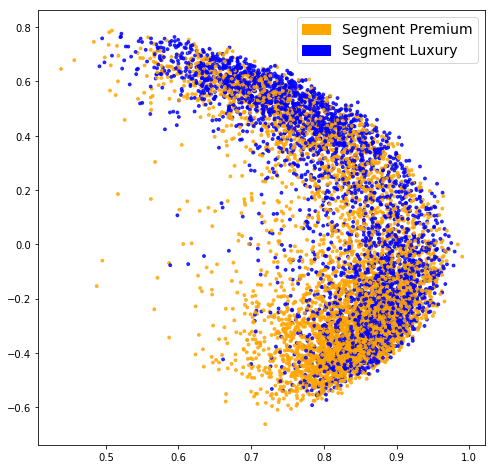

In [75]:
fig = plt.figure(figsize=(8, 8))          
plot_LSA(X_word_average, y)
plt.show()

In [76]:
# Number of topics.
ntopics=2

# Number of words to look at for each topic.
n_top_words = 20

In [77]:
# LSA
svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
wine_lsa = lsa.fit_transform(tfidf_ngram)

lsa_components = word_topic(tfidf_ngram, wine_lsa, tfidf_ngram_feat)

topwords=pd.DataFrame()
topwords['LSA']=top_words(lsa_components, n_top_words)  

In [78]:
# LDA
lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

lda_wine = lda.fit_transform(tfidf_ngram) 
lda_components = word_topic(tfidf_ngram, lda_wine, tfidf_ngram_feat)
topwords['LDA']=top_words(lda_components, n_top_words)

In [79]:
# NNMF
nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
nmf_wine = nmf.fit_transform(tfidf_ngram) 

nmf_components = word_topic(tfidf_ngram, nmf_wine, tfidf_ngram_feat)

topwords['NNMF']=top_words(nmf_components, n_top_words)

In [80]:
#for idx, topic in lda_model.print_topics(-1):
##    print("Topic: {} \nWords: {}".format(idx, topic ))
#    print("\n")

In [81]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic][0:40])

Topic 0:
              LSA             LDA            NNMF
0  rich 420.92     silki 193.44    tannin 25.88  
0  tannin 387.4    tannin 180.19   rich 25.83    
0  silki 382.88    finish 172.89   finish 25.32  
0  ripe 370.39     rich 172.41     ripe 23.97    
0  finish 365.29   soft 171.16     bodi 23.45    
0  complex 340.72  ripe 167.62     complex 17.04 
0  textur 336.41   tart 157.96     soft 15.64    
0  bodi 320.12     sweet 153.03    sweet 15.48   
0  sweet 306.59    textur 145.23   earthi 15.31  
0  soft 286.66     complex 142.94  textur 14.08  
0  good 271.99     good 137.55     balanc 13.79  
0  tart 261.19     bodi 133.28     tart 13.5     
0  crisp 237.21    earthi 131.67   structur 11.38
0  eleg 232.32     fresh 123.39    delici 11.33  
0  balanc 229.74   herb 119.03     fresh 10.64   
0  delici 227.96   candi 111.97    silki 10.46   
0  earthi 217.42   eleg 111.34     layer 9.36    
0  structur 201.1  crisp 104.68    power 9.23    
0  fine 193.36     simpl 104.66    eleg 9

## Step X: Text Classification with Logistic Regression, Random Forest and SVM

In [82]:
df_pn20_prc.iloc[:,16:40].columns

Index(['region_1_Anderson Valley', 'region_1_Arroyo Grande Valley',
       'region_1_Arroyo Seco', 'region_1_California', 'region_1_Carneros',
       'region_1_Central Coast', 'region_1_Edna Valley',
       'region_1_Green Valley', 'region_1_Monterey',
       'region_1_Monterey County', 'region_1_Napa Valley',
       'region_1_Russian River Valley', 'region_1_San Luis Obispo County',
       'region_1_Santa Barbara County', 'region_1_Santa Cruz Mountains',
       'region_1_Santa Lucia Highlands', 'region_1_Santa Maria Valley',
       'region_1_Sonoma Coast', 'region_1_Sonoma County',
       'region_1_Sta. Rita Hills', 'prc_bc', 'desc_len_bc', 'clean_desc',
       'age'],
      dtype='object')

In [83]:
X = df_pn20_prc.iloc[:,16:].drop(columns='clean_desc', axis=1)
y = df_pn20_prc['point_rank']

### Logistic Regresion

In [84]:
# SET PCA ABOVE 80% VARIANCE EXPLAINED, HOWEVER MANY COMPONENTS
selector = PCA(n_components=.90).fit(X,y)

# SELECT # COMPONENTS
#selector = PCA(n_components=10).fit(X,y)
var_explained = selector.explained_variance_ratio_ 
var_explained = pd.Series(var_explained)
#print(round(var_explained,4)) 

In [85]:
pca = PCA(n_components = 75)
logreg = LogisticRegression(solver='lbfgs',max_iter=50000)
pipeline = Pipeline([('pca', pca), ('logistic', logreg)])
score_fs_pca = cross_val_score(pipeline, X, y, scoring="accuracy", cv=3)   
print("mean={:.2f}   std=(+/- {:.2f})   all={} ".format(score_fs_pca.mean(),
                                                        score_fs_pca.std()*2, score_fs_pca))

mean=0.81   std=(+/- 0.05)   all=[0.82703107 0.83264695 0.7813553 ] 


### Random Forest Classifier

In [86]:
start_time = time.time()
print("Start Time: {}".format(time.ctime()))

pca = PCA(n_components = 90)
clf_rfc = ensemble.RandomForestClassifier(criterion='gini', n_estimators=2000, max_features='sqrt',
                                          max_depth=4, n_jobs=-1) 
clf_rfc = Pipeline([('pca', pca), ('clf', clf_rfc)])

# 7 MINUTES TO RUN
#parameter_candidates = { 
#    'clf__n_estimators': [1000,2000],
#    'clf__max_features': ['sqrt','log2'],
#    'clf__criterion': ['gini'],
#    'clf__max_depth': [2,3,4],
#    'pca__n_components': [90]
#}

# X MINUTES TO RUN
parameter_candidates = { 
    'clf__criterion': ['gini'],
    'clf__n_estimators': [2000],
    'clf__max_features': ['sqrt'],
    'clf__max_depth': [4],
    'pca__n_components': [10]
}

clf_rfc_cv_pca = GridSearchCV(estimator=clf_rfc, param_grid=parameter_candidates, cv=3, 
                              scoring='accuracy')
clf_rfc_cv_pca.fit(X, y)
#print(clf_lr.get_params().keys())

print("Elapsed Time:")
print("--- {:.2f} seconds ---".format(time.time() - start_time))
print("--- {:.2f} minutes ---".format((time.time() - start_time)/60))

Start Time: Sun Mar  1 21:04:14 2020
Elapsed Time:
--- 43.02 seconds ---
--- 0.72 minutes ---


In [87]:
print("Accuracy Best Paramaters GridSearchCV:")
print("Principal Component Analysis:\t{:.3f}".format(clf_rfc_cv_pca.best_score_))
print()
print("Best Paramaters GridSearchCV:")
print("PCA:{}".format(clf_rfc_cv_pca.best_params_))

Accuracy Best Paramaters GridSearchCV:
Principal Component Analysis:	0.796

Best Paramaters GridSearchCV:
PCA:{'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__max_features': 'sqrt', 'clf__n_estimators': 2000, 'pca__n_components': 10}


Accuracy Best Paramaters GridSearchCV:  
Principal Component Analysis:	0.795   

Best Paramaters GridSearchCV:  
PCA:{'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__max_features': 'sqrt',   'clf__n_estimators': 2000, 'pca__n_components': 90}  

### Support Vector Machine

In [88]:
start_time = time.time()
print("Start Time: {}".format(time.ctime()))

pca = PCA(n_components = 90)
clf_svc = SVC(C=10, kernel='linear')
clf_svc = Pipeline([('pca', pca), ('logistic', clf_svc)])

# SHORT TIME TO RUN, FEW MIN
parameter_candidates = [
  {'logistic__C': [10], 'logistic__kernel': ['linear']},
]

# 2 MINUTES TO RUN
#parameter_candidates = [
#  {'logistic__C': [.01, 1, 10], 'logistic__kernel': ['linear']},
#  {'logistic__C': [.01, 1, 10], 'logistic__gamma': [0.001, 0.0001], 
#   'logistic__kernel': ['rbf'], 'pca__n_components': [90]},
#]

# CREATE CLASSIFIER OBJECT AND SEARCH FOR BEST PARAMATER SETTINGS WITH GridSearchCV
clf_svc_cv_pca = GridSearchCV(estimator=clf_svc, param_grid=parameter_candidates, cv=3, 
                              scoring='accuracy')
clf_svc_cv_pca.fit(X, y);

print("Elapsed Time:")
print("--- {:.2f} seconds ---".format(time.time() - start_time))
print("--- {:.2f} minutes ---".format((time.time() - start_time)/60))

Start Time: Sun Mar  1 21:04:57 2020
Elapsed Time:
--- 20.03 seconds ---
--- 0.33 minutes ---


In [89]:
print("Accuracy Best Paramaters GridSearchCV:")
print("Principal Component Analysis:\t{:.3f}".format(clf_svc_cv_pca.best_score_))
print()
print("Best Paramaters GridSearchCV:")
print("PCA:{}".format(clf_svc_cv_pca.best_params_))

Accuracy Best Paramaters GridSearchCV:
Principal Component Analysis:	0.815

Best Paramaters GridSearchCV:
PCA:{'logistic__C': 10, 'logistic__kernel': 'linear'}


Accuracy Best Paramaters GridSearchCV:  
Principal Component Analysis:	0.815  

Best Paramaters GridSearchCV:  
PCA:{'logistic__C': 10, 'logistic__kernel': 'linear'}  

#### CONFUSION MATRIX ... UPDATE CODE ... DO TEST SPLIT NOT CV
https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb

In [93]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

In [94]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [95]:
X = df_pn20_prc.iloc[:,16:].drop(columns='clean_desc', axis=1)
y = df_pn20_prc['point_rank']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [96]:
clf_tfidf = LogisticRegression(solver='lbfgs',max_iter=50000, random_state=42)
clf_tfidf.fit(X_train, y_train)
y_predicted_tfidf = clf_tfidf.predict(X_test)

In [97]:
# !!! GO BACK AND FIND OUTPUT I LIKE
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.821, precision = 0.821, recall = 0.821, f1 = 0.821


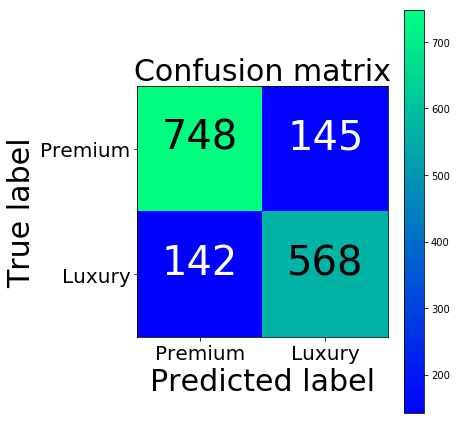

TFIDF confusion matrix
[[748 145]
 [142 568]]


In [98]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(6, 6))
# CAN HAVE MULTIPLE CLASSES
plot = plot_confusion_matrix(cm2, classes=['Premium','Luxury'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)

# !!! SPEAK TO CLASSIFICATION AND SCORES, PARTICULARLY, PRECISION, RECALL, TYPE I AND TYPE II

### Step X: KNN - Suggest varietals to user based on nearest neighbor

In [99]:
df.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'variety', 'winery', 'taster_name',
       'taster_twitter_handle', 'title'],
      dtype='object')

In [100]:
from scipy.sparse import csr_matrix
col = ['province','variety','points']

wine1 = df[col]
wine1 = wine1.dropna(axis=0)
wine1 = wine1.drop_duplicates(['province','variety'])
wine1 = wine1[wine1['points'] > 85]

wine_pivot = wine1.pivot(index= 'variety',columns='province',values='points').fillna(0)
wine_pivot_matrix = csr_matrix(wine_pivot)

In [101]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=10, algorithm= 'brute', metric= 'cosine')
model_knn = knn.fit(wine_pivot_matrix)

#print(n, query_index)
0 440
Recommendation for ## Rhône-style Red Blend ##:
1: Mourvèdre with distance: 0.4059726437051525
2: G-S-M with distance: 0.42855783116475255
3: Grenache with distance: 0.51691070018853
4: Viognier with distance: 0.5252986001118718
5: Syrah-Grenache with distance: 0.5374953561577163


1 438
Recommendation for ## Red Blend ##:
1: White Blend with distance: 0.46765354317710184
2: Cabernet Sauvignon with distance: 0.490981973122009
3: Syrah with distance: 0.5312093839609187
4: Merlot with distance: 0.5544116312705762
5: Cabernet Franc with distance: 0.5572682188471446

In [102]:
for n in range(5):
    #query_index = wine_pivot.loc("Zinfandel")
    query_index = np.random.choice(wine_pivot.shape[0])
    #print(n, query_index)
    distance, indice = model_knn.kneighbors(wine_pivot.iloc[query_index,:].values.reshape(1,-1), n_neighbors=6)
    for i in range(0, len(distance.flatten())):
        if  i == 0:
            print('Recommendation for ## {0} ##:'.format(wine_pivot.index[query_index]))
        else:
            print('{0}: {1} with distance: {2}'.format(i,wine_pivot.index[indice.flatten()[i]],distance.flatten()[i]))
    print('\n')

Recommendation for ## Rkatsiteli ##:
1: Mtsvane with distance: 0.2888100861978613
2: Kisi with distance: 0.28907775672043257
3: Other with distance: 0.4832602190058237
4: Valvin Muscat with distance: 0.5001104292556338
5: Riesling-Chardonnay with distance: 0.5001104292556338


Recommendation for ## Muscadel ##:
1: Muscadelle with distance: 0.31827701936927744
2: Tokay with distance: 0.39177481272932513
3: Mansois with distance: 0.4293969892615318
4: Abouriou with distance: 0.4293969892615318
5: Ondenc with distance: 0.4293969892615318


Recommendation for ## Pinot-Chardonnay ##:
1: Arneis with distance: 4.2562246361455e-05
2: Dolcetto with distance: 0.1390089826881773
3: Muscat Canelli with distance: 0.3252693782602193
4: Edelzwicker with distance: 0.32961622563099535
5: Refosco with distance: 0.4069947193930099


Recommendation for ## Mazuelo ##:
1: Verdejo-Sauvignon Blanc with distance: 0.0
2: Tinta del Toro with distance: 0.0
3: Tinta Fina with distance: 0.0
4: Mazuelo with distance

### Step X: KNN - Suggest varietals to user based on nearest neighbor

In [103]:
# DUPLICATES APPEAR TO BE IN DATAFRAME ROWS, LIKELY ALL ZEROS
df_tfidf_ngram_wine[df_tfidf_ngram_wine.duplicated(keep=False)==True].head(2)

,age,ageabl,ager,appeal,appel,approach,balanc,beauti,best,better,...,tough,unrip,veget,velveti,vibrant,wave,young,youth,zest,zesti
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

In [105]:
wine1 = df.copy()

In [106]:
# Lets choice rating of wine is points, title as user_id, and variety,
col = ['province','variety','points']
wine1 = df[col]
wine1 = wine1.dropna(axis=0)
wine1 = wine1.drop_duplicates(['province','variety'])
wine1 = wine1[wine1['points'] > 85]
wine_pivot = wine1.pivot(index= 'variety',columns='province',values='points').fillna(0)
wine_pivot_matrix = csr_matrix(wine_pivot)

In [107]:
knn = NearestNeighbors(n_neighbors=10,algorithm= 'brute', metric= 'cosine')
model_knn = knn.fit(wine_pivot_matrix)

In [108]:
query_index = np.random.choice(wine_pivot.shape[0])
distance, indice = model_knn.kneighbors(wine_pivot.iloc[query_index,:].values.reshape(1,-1),n_neighbors=6)
for i in range(0, len(distance.flatten())):
    if  i == 0:
        print('Recommendation for {0}:\n'.format(wine_pivot.index[query_index]))
    else:
        print('{0}: {1} with distance: {2}'.format(i,wine_pivot.index[indice.flatten()[i]],distance.flatten()[i]))

Recommendation for Semillon-Sauvignon Blanc:

1: Semillon-Chardonnay with distance: 0.41439363814783925
2: Grenache-Shiraz with distance: 0.42046037279242365
3: Shiraz-Grenache with distance: 0.4247662037713207
4: Cabernet Sauvignon-Merlot-Shiraz with distance: 0.5273822547558942
5: Chardonnay-Semillon with distance: 0.5298979382578828


# !!! PUT IN SUMMARY

INCLUDE WEAKNESSES

INCLUDE PROPOSAL FOR FURTHER RESEARCH
BIAS

GO OVER CAPSTONE 4 AND REVIEW

GO OVER THINKFUL DESCRIPTION AND MY PROJECT PLAN AND MAKE SURE HIT POINTS

SPEAK TO THE "APP" AND GIVE RELEVANCE

TALK ABOUT HOW TO BRING IT ALL TOGETHER

HOW TO USE WORD2VEC MORE EFFECTIVELY, CLEARLY GOOD RESULTS, BUT DOESN'T TRANSLATE TO MODEL

In [109]:
# SIMPLE FILTERING MODELS
# TAKE REGION POINT / PRICE MAKE A RATIO, 
# ACTUAL POINT / REGION MEAN POINT 
# ACTUAL PRICE / REGION MEAN PRICE
# SIMPLE MODEL COULD BE  IF POINT RATIO > 1 AND PRICE RATIO < 1, THEN VALUE FOR REGION
# ANOTHER SIMPLE MODEL WOULD BE IF POINT_RANK IS > REGION POINT RANK AND PRICE RANK IS <= REGION PRICE RANK